<a href="https://colab.research.google.com/github/ImajiPietersz/FYP/blob/main/GAN_separate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
DATASET_PATH = '/content/drive/MyDrive/FYP18-machine-vibration-source-separation/ LoRaWAN dataset/machine2_with_noise.csv'
IMP_COL = ['XOAVelocity', 'XPeakmg', 'XRMSmg', 'XKurtosis',
       'XCrestFactor', 'XSkewness', 'XDeviation', 'XPeaktoPeakDisplacement',
       'YOAVelocity', 'YPeakmg', 'YRMSmg', 'ZOAVelocity', 'ZPeakmg', 'ZRMSmg','converted', 'target']
X_COL = ['XOAVelocity', 'XPeakmg', 'XRMSmg', 'XKurtosis',
       'XCrestFactor', 'XSkewness', 'XDeviation', 'XPeaktoPeakDisplacement',
       'YOAVelocity', 'YPeakmg', 'YRMSmg', 'ZOAVelocity', 'ZPeakmg','converted', 'ZRMSmg']
TAR_COL = 'target'

In [6]:
df = pd.read_csv(DATASET_PATH)[IMP_COL]
df.columns
# df.sort_values(by='converted', inplace = True)
df = df.drop(['converted'], axis=1)

<ipython-input-7-2d366cf5db0b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.target -= 1
<ipython-input-7-2d366cf5db0b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.target *= 40


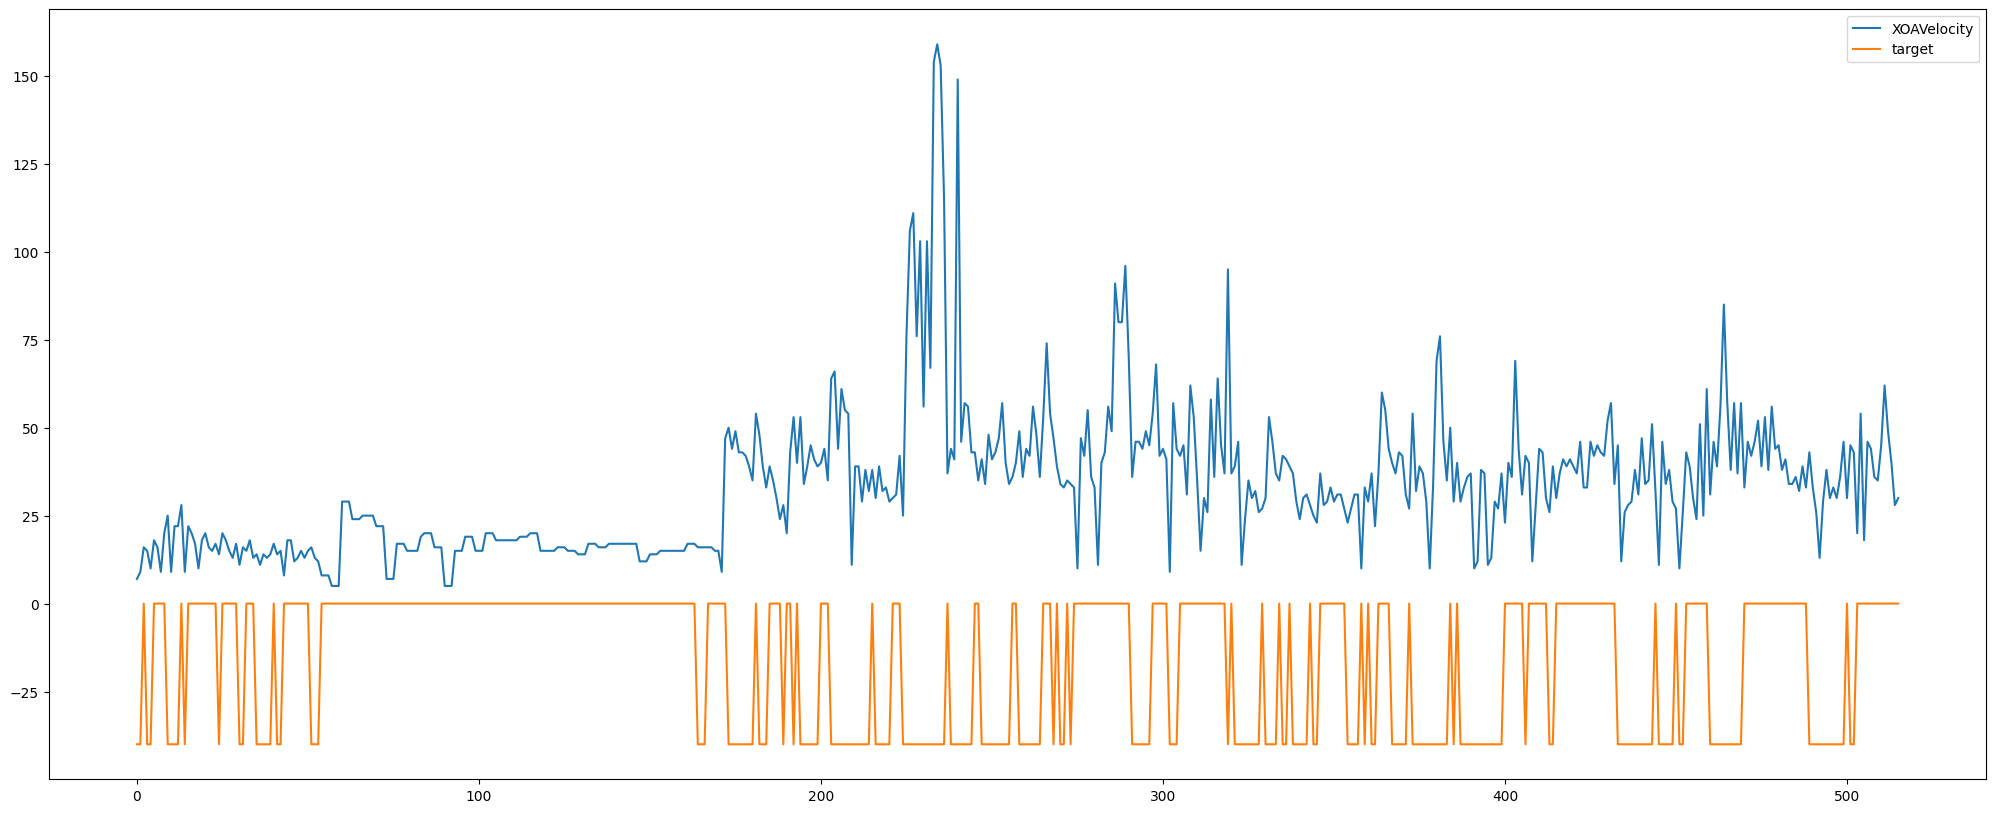

In [7]:
df1 = df.drop(['XCrestFactor','ZPeakmg','ZRMSmg'], axis=1)
df1 = df[['XOAVelocity','target']]
df1.target -= 1
df1.target *= 40
plt.figure(figsize=(25,10)) 
plt.plot(df1)
plt.legend(df1.columns)
plt.show()

In [8]:
def generateFrames(size = 6,overlap = True):
  # generate overlapping frames
  list_of_dfs = [df.loc[i:i+size-1,:] for i in range(0, len(df), 1 if overlap else size) if i < len(df) - size]
  
  data = []
  labels = []

  for d in list_of_dfs:
    if(len(d)==size):
      values = d[['XOAVelocity']].values.flatten()
      min_val = tf.reduce_min(values)
      max_val = tf.reduce_max(values)
      values = (values - min_val) / (max_val - min_val)
      data.append(values)

      # label as 1 if not noisy false otherwise
      labels.append(d['target'].sum() < 2)

  labels = np.asarray(labels, dtype=bool) 
  data = np.array(data)

  return (data,labels)

def splitTrainTest(ratio, data, labels):
  
  x_train, x_test,_ = np.split(data, [round(len(data) * ratio), len(data)])
  labels_train, labels_test,_ = np.split(labels, [round(len(labels) * ratio), len(labels)])

  return (x_train,labels_train, x_test,labels_test)

In [9]:
frames, labels = generateFrames(12)
train_data, train_labels, test_data, test_labels = splitTrainTest(0.7, frames, labels)

(len(train_data),len(test_data))


(353, 151)

In [10]:
model = tf.keras.Sequential([
    # todo:  no longer multivarite
    tf.keras.layers.Dense(12, activation='softmax'),
    tf.keras.layers.Dense(6, activation='softmax'),
    tf.keras.layers.Dense(3, activation='softmax'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_data, train_labels, epochs=10)

Epoch 1/10
12/12 [==============================] - 2s 3ms/step - loss: 0.6887 - accuracy: 0.9377
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6692 - accuracy: 0.9377
Epoch 3/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.9377
Epoch 4/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6325 - accuracy: 0.9377
Epoch 5/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6156 - accuracy: 0.9377
Epoch 6/10
12/12 [==============================] - 0s 3ms/step - loss: 0.5996 - accuracy: 0.9377
Epoch 7/10
12/12 [==============================] - 0s 3ms/step - loss: 0.5843 - accuracy: 0.9377
Epoch 8/10
12/12 [==============================] - 0s 3ms/step - loss: 0.5701 - accuracy: 0.9377
Epoch 9/10
12/12 [==============================] - 0s 3ms/step - loss: 0.5562 - accuracy: 0.9377
Epoch 10/10
12/12 [==============================] - 0s 4ms/step - loss: 0.5446 - accuracy: 0.9377


In [11]:
test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

5/5 - 0s - loss: 0.5769 - accuracy: 0.8411 - 183ms/epoch - 37ms/step

Test accuracy: 0.8410596251487732


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses

from tensorflow.keras.models import Model

class AutoEnc(Model):
  def __init__(self):
    super(AutoEnc, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(24, activation="relu"),
      layers.Dense(12, activation="relu"),
      layers.Dense(6, activation="relu"),
      layers.Dense(3, activation="relu")
      ])

    self.decoder = tf.keras.Sequential([
      layers.Dense(6, activation="relu"),
      layers.Dense(8, activation="relu"),
      layers.Dense(12, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AutoEnc()
autoencoder.compile(optimizer='adam', loss='mae')

history = autoencoder.fit(train_data, train_data, 
          epochs=20, 
          validation_data=(test_data, test_data),
         )
 


Epoch 1/20
12/12 [==============================] - 2s 23ms/step - loss: 0.2974 - val_loss: 0.2393
Epoch 2/20
12/12 [==============================] - 0s 7ms/step - loss: 0.2972 - val_loss: 0.2392
Epoch 3/20
12/12 [==============================] - 0s 6ms/step - loss: 0.2970 - val_loss: 0.2392
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 0.2968 - val_loss: 0.2391
Epoch 5/20
12/12 [==============================] - 0s 5ms/step - loss: 0.2966 - val_loss: 0.2388
Epoch 6/20
12/12 [==============================] - 0s 5ms/step - loss: 0.2961 - val_loss: 0.2387
Epoch 7/20
12/12 [==============================] - 0s 7ms/step - loss: 0.2955 - val_loss: 0.2383
Epoch 8/20
12/12 [==============================] - 0s 6ms/step - loss: 0.2949 - val_loss: 0.2378
Epoch 9/20
12/12 [==============================] - 0s 7ms/step - loss: 0.2940 - val_loss: 0.2376
Epoch 10/20
12/12 [==============================] - 0s 6ms/step - loss: 0.2930 - val_loss: 0.2375
Epoch 11/20
12/12 

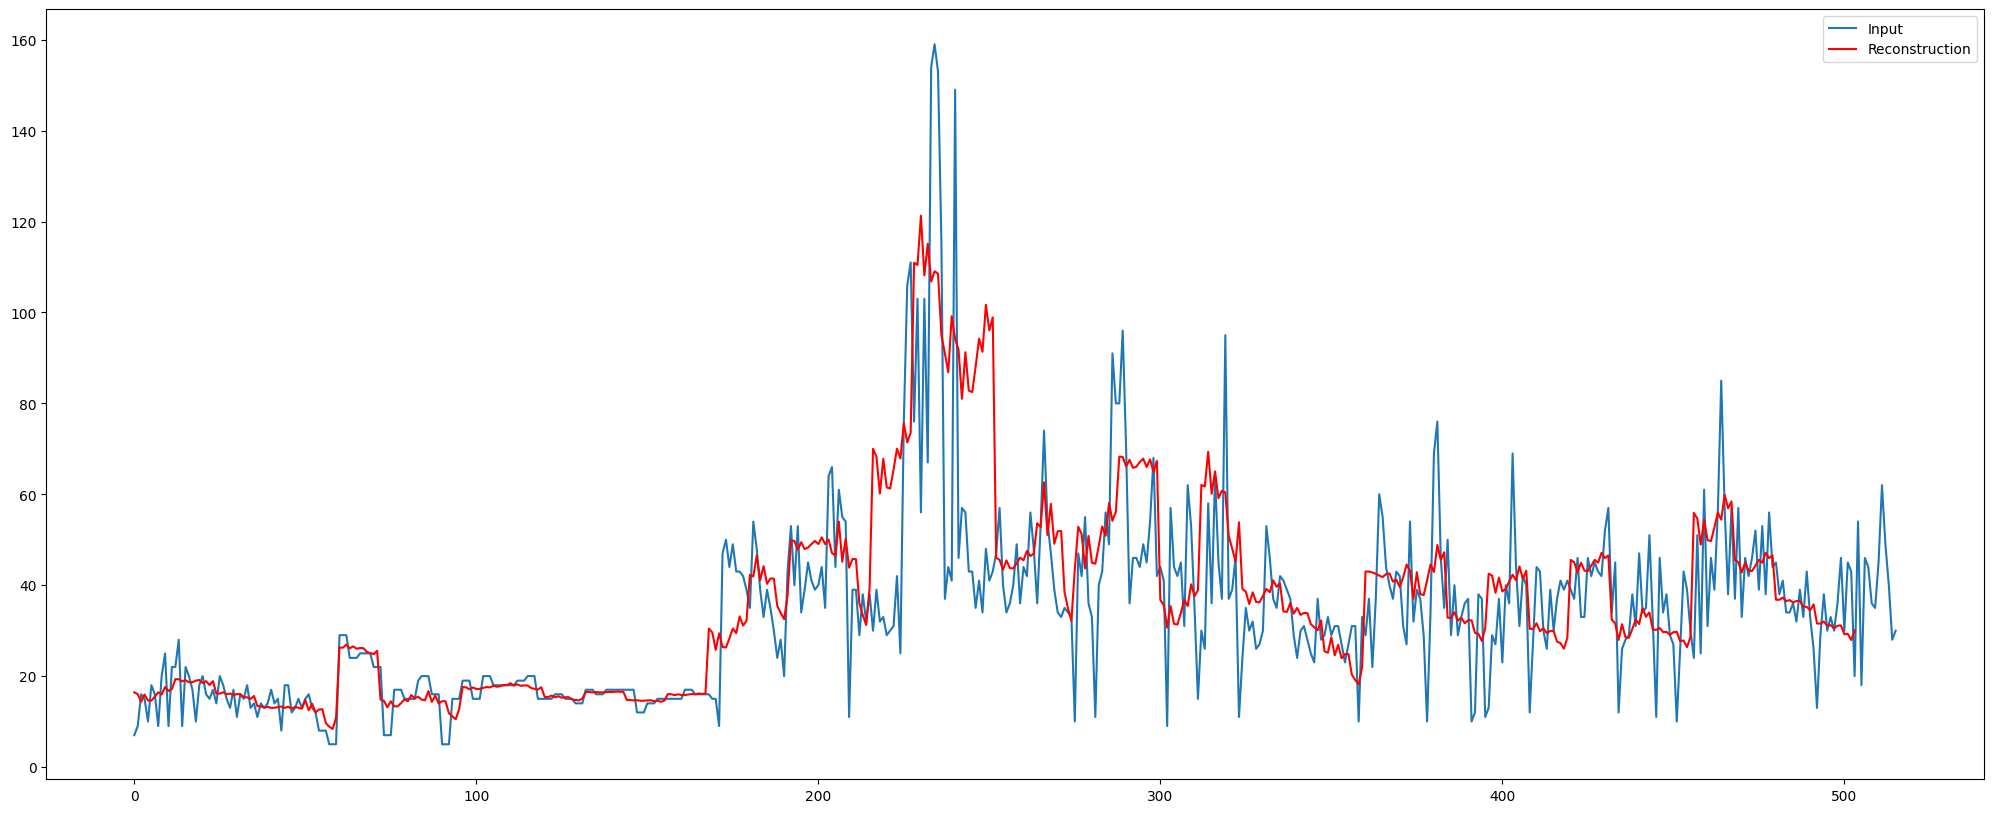

In [13]:
size = 12

list_of_dfs = [df.loc[i:i+size-1,:] for i in range(0, len(df), 12) if i < len(df) - 12]
  
denoised = []

for d in list_of_dfs:
  if(len(d) == size):
    values = d[['XOAVelocity']].values.flatten()
    min_val = tf.reduce_min(values)
    max_val = tf.reduce_max(values)
    values = (values - min_val) / (max_val - min_val)
    encoded_data = autoencoder.encoder( np.array([values])).numpy()
    [values] = autoencoder.decoder(encoded_data).numpy()
    values = (np.array(values) * (max_val - min_val).numpy())   + min_val.numpy()
    denoised = np.concatenate((np.array(denoised) , np.array(values)))

denoised = np.array(denoised)
noise = df[['XOAVelocity']].values.flatten()

plt.figure(figsize=(25,10)) 
plt.plot(noise)
plt.plot(denoised, color="red")
plt.legend(labels=["Input", "Reconstruction" ])
plt.show()

In [15]:
class Discriminator(Model):
   def __init__(self):
    super(Discriminator, self).__init__()
    self.model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(12,) ),
        tf.keras.layers.Dense(12, activation='softmax'),
        tf.keras.layers.Dense(6, activation='softmax'),
        tf.keras.layers.Dense(3, activation='softmax'),
        tf.keras.layers.Dense(1)
    ])
  
   def call(self, x):
    return self.model(x)
 

class Generator(Model):
  def __init__(self):
    super(Generator, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(24, activation="relu"),
      layers.Dense(12, activation="relu"),
      layers.Dense(6, activation="relu"),
      layers.Dense(3, activation="relu")
      ])

    self.decoder = tf.keras.Sequential([
      layers.Dense(6, activation="relu"),
      layers.Dense(8, activation="relu"),
      layers.Dense(12, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

generator = Generator()
discriminator = Discriminator()

generator.compile(optimizer='adam', loss='mae')
discriminator.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])

# generator.fit(train_data, train_data, epochs = 20, validation_data=(test_data, test_data))
discriminator.fit(train_data, train_labels, epochs=10)

# real --> Without noise
# fake -> With noise

Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.7010 - accuracy: 0.9377
Epoch 2/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6792 - accuracy: 0.9377
Epoch 3/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6583 - accuracy: 0.9377
Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6375 - accuracy: 0.9377
Epoch 5/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6175 - accuracy: 0.9377
Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.5983 - accuracy: 0.9377
Epoch 7/10
12/12 [==============================] - 0s 3ms/step - loss: 0.5795 - accuracy: 0.9377
Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.5614 - accuracy: 0.9377
Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.5439 - accuracy: 0.9377
Epoch 10/10
12/12 [==============================] - 0s 3ms/step - loss: 0.5272 - accuracy: 0.9377


In [16]:
test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

5/5 - 0s - loss: 0.5769 - accuracy: 0.8411 - 173ms/epoch - 35ms/step

Test accuracy: 0.8410596251487732
